# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
# Import numpy and pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [13]:
# Run this code:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sensor = pd.read_csv("/kaggle/input/datatnd/sub_1.csv")
sensor.drop(columns=['Unnamed: 0'], inplace=True)



/kaggle/input/datatnd/sub_1.csv


Examine the data using the `head` function.

In [14]:
# Your code here:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [15]:
# Your code here:
sensor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   attitude.roll       1751 non-null   float64
 1   attitude.pitch      1751 non-null   float64
 2   attitude.yaw        1751 non-null   float64
 3   gravity.x           1751 non-null   float64
 4   gravity.y           1751 non-null   float64
 5   gravity.z           1751 non-null   float64
 6   rotationRate.x      1751 non-null   float64
 7   rotationRate.y      1751 non-null   float64
 8   rotationRate.z      1751 non-null   float64
 9   userAcceleration.x  1751 non-null   float64
 10  userAcceleration.y  1751 non-null   float64
 11  userAcceleration.z  1751 non-null   float64
dtypes: float64(12)
memory usage: 164.3 KB


How many rows and columns are in our data?

In [16]:
# Your code here:

sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [17]:
# Your code here:
infer=pd.date_range('1/1/2018 00:00:00','1/1/2018 00:29:10', periods=1751)
infer


DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:00:01',
               '2018-01-01 00:00:02', '2018-01-01 00:00:03',
               '2018-01-01 00:00:04', '2018-01-01 00:00:05',
               '2018-01-01 00:00:06', '2018-01-01 00:00:07',
               '2018-01-01 00:00:08', '2018-01-01 00:00:09',
               ...
               '2018-01-01 00:29:01', '2018-01-01 00:29:02',
               '2018-01-01 00:29:03', '2018-01-01 00:29:04',
               '2018-01-01 00:29:05', '2018-01-01 00:29:06',
               '2018-01-01 00:29:07', '2018-01-01 00:29:08',
               '2018-01-01 00:29:09', '2018-01-01 00:29:10'],
              dtype='datetime64[ns]', length=1751, freq=None)

Assign the time series index to the dataframe's index.

In [18]:
# Your code here:

sensor=sensor.set_index(infer)
sensor

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740
2018-01-01 00:29:09,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

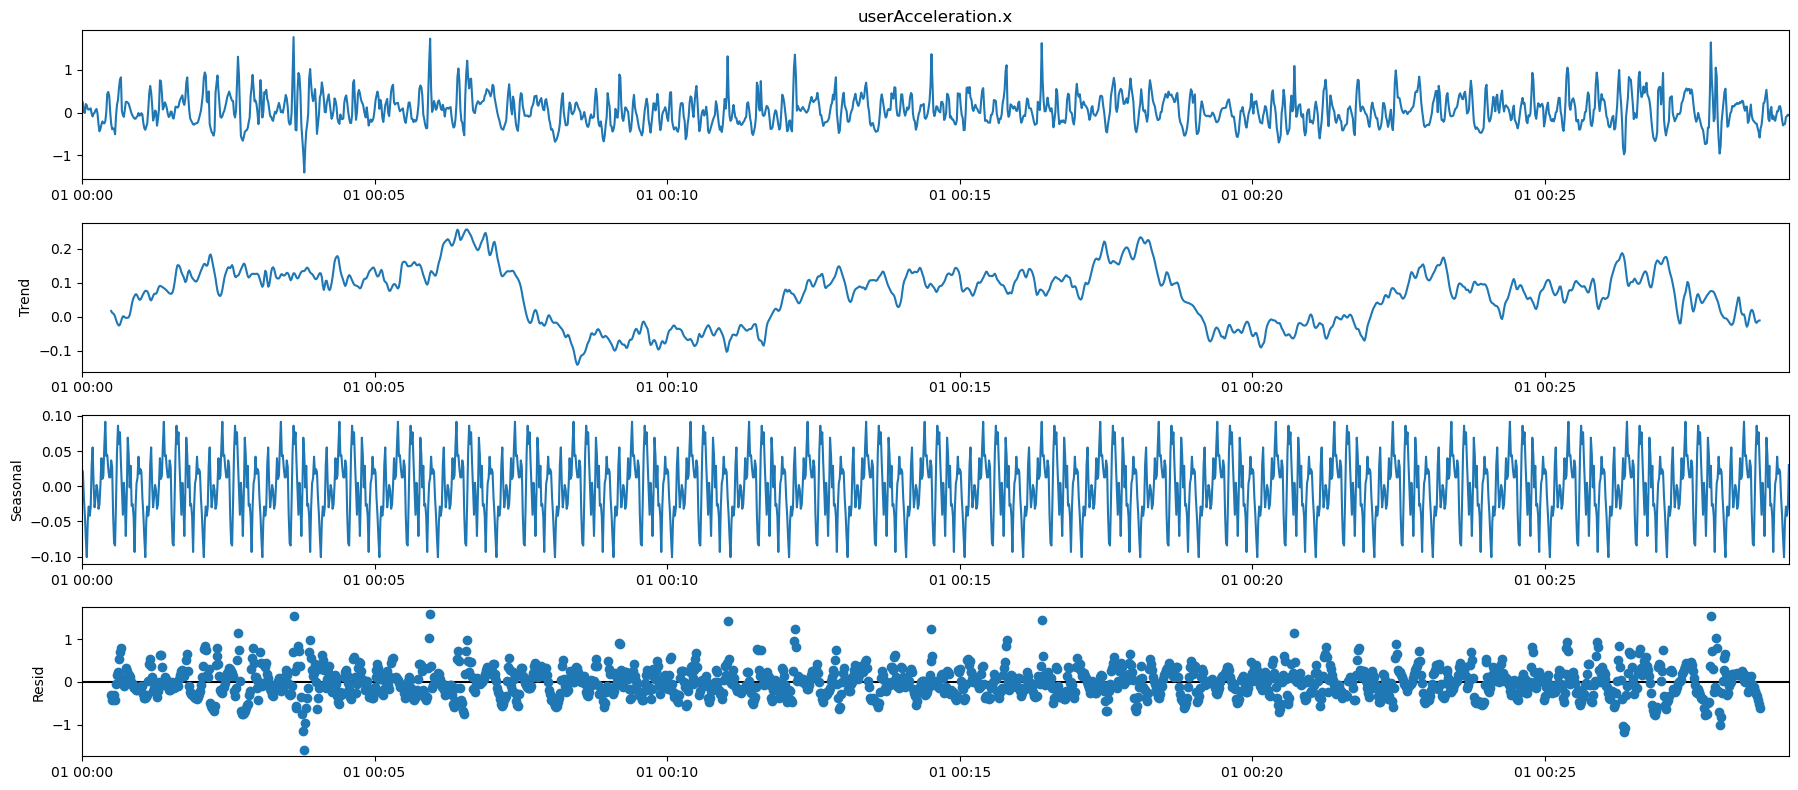

In [22]:
# Your code here:
import statsmodels.api as sm
from pylab import rcParams

from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition =sm.tsa.seasonal_decompose(sensor['userAcceleration.x'], model='additive',period = 60)
fig = decomposition.plot()
plt.show()


Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

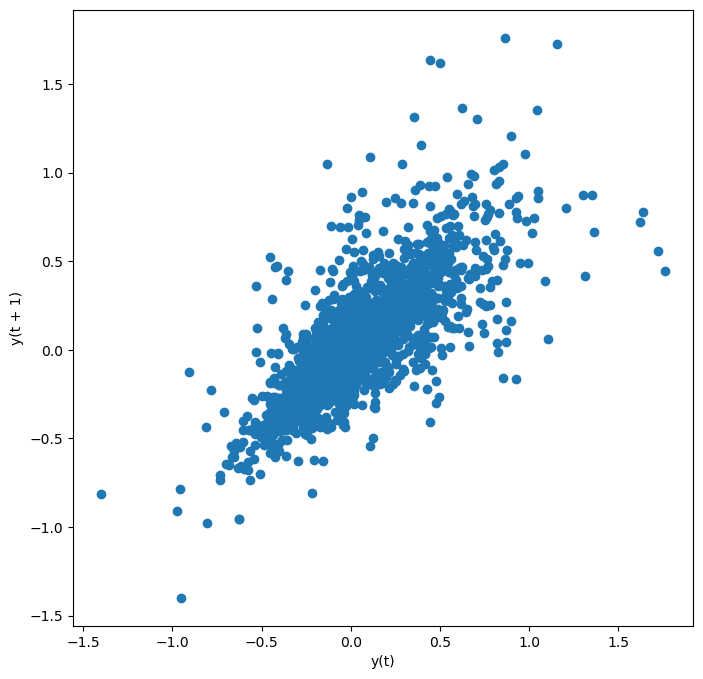

In [23]:
# Your code here:

fig=plt.figure(figsize=(8,8))
pd.plotting.lag_plot(sensor['userAcceleration.x'],lag=1)

Create a lag plot for `rotationRate.x`

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

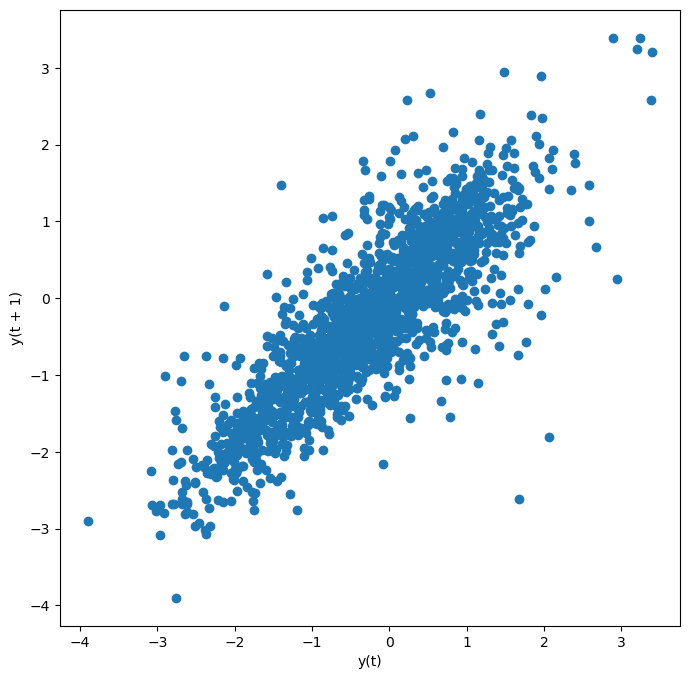

In [24]:
# Your code here:
fig=plt.figure(figsize=(8,8))
pd.plotting.lag_plot(sensor['rotationRate.x'],lag=1)


What are your conclusions from both visualizations?

In [25]:
# Your conclusions here:

print('high corr')

high corr


The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [26]:
# Your code here:
from statsmodels.tsa.stattools import adfuller
print('Los datos son estacionarios')
dftest = adfuller(sensor['userAcceleration.x']  , autolag=None)

print(f'Prueba estadística {dftest[0]}')
print(f'P-Value{dftest[1]}')
print(f'Valores críticos:')
for k, v in dftest[4].items():
    print('\t{}:{} Los datos son {} estacionarios con {}% de confianza'.format(k, v, "not" if v < dftest[0] else "", 100-int(k[:-1])))


Los datos son estacionarios
Prueba estadística -8.160095026835917
P-Value9.193147705719652e-13
Valores críticos:
	1%:-3.4341465551936534 Los datos son  estacionarios con 99% de confianza
	5%:-2.863216966926812 Los datos son  estacionarios con 95% de confianza
	10%:-2.567662770090317 Los datos son  estacionarios con 90% de confianza


What are your conclusions from this test?

In [27]:
# Your conclusions here:

print('los datos son estacionarios')

los datos son estacionarios


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [35]:
# Your code here:
#import statsmodels.tsa.arima.model.ARIMA
#from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(trainset, order=(1,1,2))
result = model.fit()

test_set=sensor['userAcceleration.x'][-10:]
trainset=sensor['userAcceleration.x'][:-10]

model = sm.tsa.arima.ARIMA(trainset, order=(1,1,2))
result = model.fit()

#mod=ARMA(trainset, order=(2,1))
#results = mod.fit()

fore= result.forecast(steps=10)[0]
fore

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
/opt/conda/lib

0.17154990463371284

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [36]:
# Your code here:

from statsmodels.tools.eval_measures import rmse

rmse(test_set,fore)

0.3148064672936218

In [38]:
predict_2=result.predict(trainset.index[0],trainset.index[-1])
rmse(trainset,predict_2)

0.20011546142887168